In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


ugh we're doing linear regression as an example kill me

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step, device="mps").unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], device='mps:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]], device='mps:0'))

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

In [4]:
# split train & test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train.cpu().numpy(), 
                     train_labels=y_train.cpu().numpy(), 
                     test_data=X_test.cpu().numpy(), 
                     test_labels=y_test.cpu().numpy(), 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions.cpu().numpy(), c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

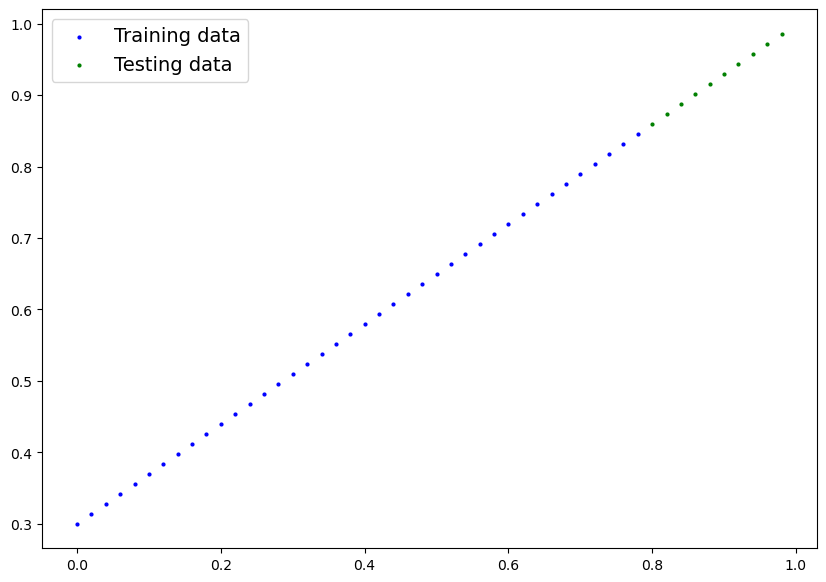

In [6]:
plot_predictions()

In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float,# <- PyTorch loves float32 by default
                                               device="mps"), 
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float,# <- PyTorch loves float32 by default
                                            device="mps"), 
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

In [8]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.9047], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([-1.5057], device='mps:0', requires_grad=True)]

In [9]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.9047], device='mps:0')),
             ('bias', tensor([-1.5057], device='mps:0'))])

In [10]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)
# `torch.inference_mode()` turns off a bunch of things (like gradient 
# tracking) to make forward-passes faster.

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[-0.7819],
        [-0.7638],
        [-0.7457],
        [-0.7276],
        [-0.7095],
        [-0.6914],
        [-0.6734],
        [-0.6553],
        [-0.6372],
        [-0.6191]], device='mps:0')


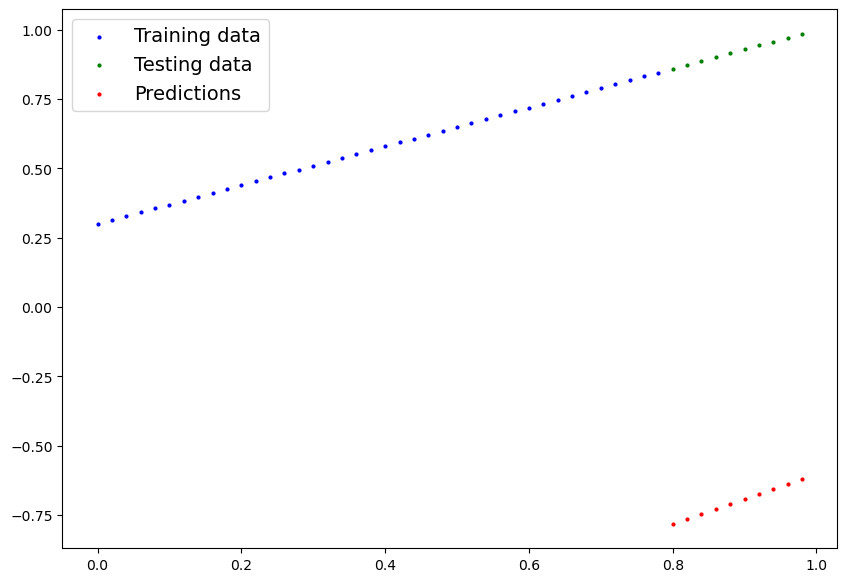

In [12]:
plot_predictions(predictions=y_preds)

In [13]:
y_test - y_preds # residuals

tensor([[1.6419],
        [1.6378],
        [1.6337],
        [1.6296],
        [1.6255],
        [1.6214],
        [1.6174],
        [1.6133],
        [1.6092],
        [1.6051]], device='mps:0')

In [14]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01) #learning rate

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

In [15]:
torch.manual_seed(69)

epochs = 501
train_loss_vals = []
test_loss_vals = []
epoch_ct = []

for epoch in range(epochs):
    ### Training
    
    # put model in training mode - which is default state so kinda unnecessary?
    model_0.train()
    
    # fwd pass
    y_pred = model_0(X_train)
    
    # calc loss
    loss = loss_fn(y_pred, y_train) # earlier this was set to MAE
    
    # set grad to 0
    optimizer.zero_grad()
    
    # calculate gradient using the loss
    loss.backward()
    
    # performs backprop by telling the optimizer to update parameters
    optimizer.step()
    
    ### testing
    
    # put model in eval mode so it doesn't track gradients (much faster than if u forget)
    model_0.eval()
    
    with torch.inference_mode():
        # fwd pass on test data
        test_pred = model_0(X_test)
        
        # calc loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        # predictions come in torch.float (float32) datatype so just gotta double make sure test values do too
        
        # print
        if epoch % 10 == 0:
            epoch_ct.append(epoch)
            train_loss_vals.append(loss.detach().cpu().numpy())
            test_loss_vals.append(test_loss.detach().cpu().numpy())
            # cuz we don't want those pesky tensor values for simple debugs
            
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
    

/Users/tunadorable/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 | MAE Train Loss: 1.7258310317993164 | MAE Test Loss: 1.6100212335586548
Epoch: 10 | MAE Train Loss: 1.6106213331222534 | MAE Test Loss: 1.4753113985061646
Epoch: 20 | MAE Train Loss: 1.4954112768173218 | MAE Test Loss: 1.3406015634536743
Epoch: 30 | MAE Train Loss: 1.3802013397216797 | MAE Test Loss: 1.205891489982605
Epoch: 40 | MAE Train Loss: 1.2649911642074585 | MAE Test Loss: 1.0711809396743774
Epoch: 50 | MAE Train Loss: 1.1497811079025269 | MAE Test Loss: 0.936470627784729
Epoch: 60 | MAE Train Loss: 1.0345710515975952 | MAE Test Loss: 0.8017603158950806
Epoch: 70 | MAE Train Loss: 0.9193609356880188 | MAE Test Loss: 0.6670500040054321
Epoch: 80 | MAE Train Loss: 0.8041507601737976 | MAE Test Loss: 0.5323395729064941
Epoch: 90 | MAE Train Loss: 0.688940703868866 | MAE Test Loss: 0.3976292312145233
Epoch: 100 | MAE Train Loss: 0.5737306475639343 | MAE Test Loss: 0.2629188597202301
Epoch: 110 | MAE Train Loss: 0.4585205018520355 | MAE Test Loss: 0.12820850312709808
Epoch

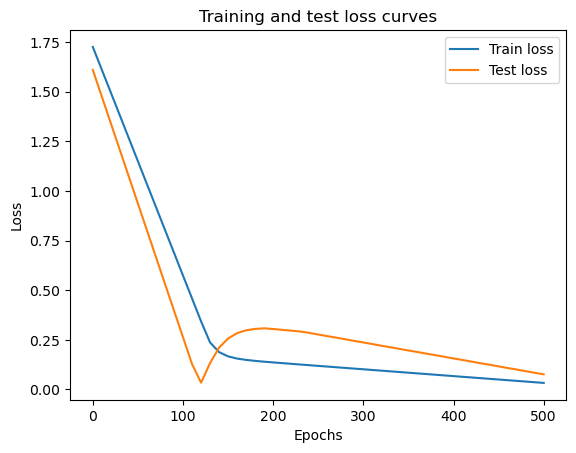

In [16]:
# Plot the loss curves
plt.plot(epoch_ct, train_loss_vals, label="Train loss")
plt.plot(epoch_ct, test_loss_vals, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

^ so in the guide i'm watching they only did 100 epochs whereas i did 500 so they didn't see the double-descent curve. but also since this is a stupid linear function and my learning rate was constant my model went a bit crazy and ended up with a higher test loss than theirs at the end of the day. funny

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.8616], device='mps:0')), ('bias', tensor([0.2323], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# makign predictions

In [19]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  #model_0.to("mps")
  #X_test = X_test.to("mps")
  y_preds = model_0(X_test)
y_preds

tensor([[0.9216],
        [0.9388],
        [0.9561],
        [0.9733],
        [0.9905],
        [1.0077],
        [1.0250],
        [1.0422],
        [1.0594],
        [1.0767]], device='mps:0')

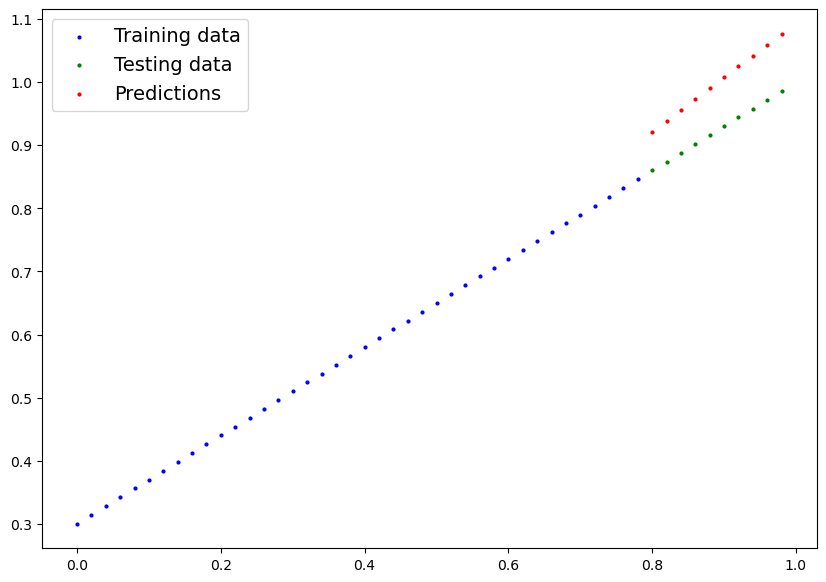

In [20]:
plot_predictions(predictions=y_preds)

# saving & loading a model

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

In [21]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "stupid_regression_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/stupid_regression_model_0.pth


In [22]:
# Check the saved file path
!ls -l models/stupid_regression_model_0.pth

-rw-r--r--  1 tunadorable  staff  1199 Sep 30 19:10 models/stupid_regression_model_0.pth


Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).
> The disadvantage of *saving the whole model* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

In [23]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) 

In [25]:
# Compare previous model predictions with loaded model predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')

In [28]:
# this one is sipmler to type taking advantage of the in-buit nn.Linear() function
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1,
                                     bias = True)
        
    # gotta define the forward computation
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [29]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

notice "linear_layer" was the name defined in "self.linear_layer = ..." so really that's how this dictionary works with generalizing layer names, you name them yourself

In [30]:
# checking device
next(model_1.parameters()).device

device(type='cpu')

In [32]:
# set model to MPS if available, otherwise default to CPU
if torch.backends.mps.is_available():
    model_1.to("mps")
else:
    print ("MPS device not found.")
    
next(model_1.parameters()).device

device(type='mps', index=0)

In [34]:
# Create loss function
loss_fn = nn.MSELoss() # let's go MSE

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.001) # smaller learning rate should let it get closer

In [35]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1001

# Put data on the available device
# Without this, error will happen (not all model/data on device)
device="mps"
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.3084445595741272 | Test loss: 0.34334543347358704
Epoch: 100 | Train loss: 0.1942005604505539 | Test loss: 0.20442505180835724
Epoch: 200 | Train loss: 0.12238439172506332 | Test loss: 0.11982319504022598
Epoch: 300 | Train loss: 0.07723750919103622 | Test loss: 0.06877640634775162
Epoch: 400 | Train loss: 0.04885372892022133 | Test loss: 0.03835875540971756
Epoch: 500 | Train loss: 0.031007084995508194 | Test loss: 0.020545637235045433
Epoch: 600 | Train loss: 0.019783765077590942 | Test loss: 0.010370250791311264
Epoch: 700 | Train loss: 0.012723800726234913 | Test loss: 0.004772069863975048
Epoch: 800 | Train loss: 0.008280877955257893 | Test loss: 0.0018752992618829012
Epoch: 900 | Train loss: 0.005483008921146393 | Test loss: 0.0005386347183957696
Epoch: 1000 | Train loss: 0.0037192830350250006 | Test loss: 7.435533188981935e-05


> **Note:** Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending on whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device. If the difference is large, you may want to look for errors, however, if it is small (ideally it is), you can ignore it.

In [39]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6002]], device='mps:0')), ('linear_layer.bias', tensor([0.3953], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [40]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8754],
        [0.8874],
        [0.8994],
        [0.9114],
        [0.9234],
        [0.9354],
        [0.9474],
        [0.9595],
        [0.9715],
        [0.9835]], device='mps:0')

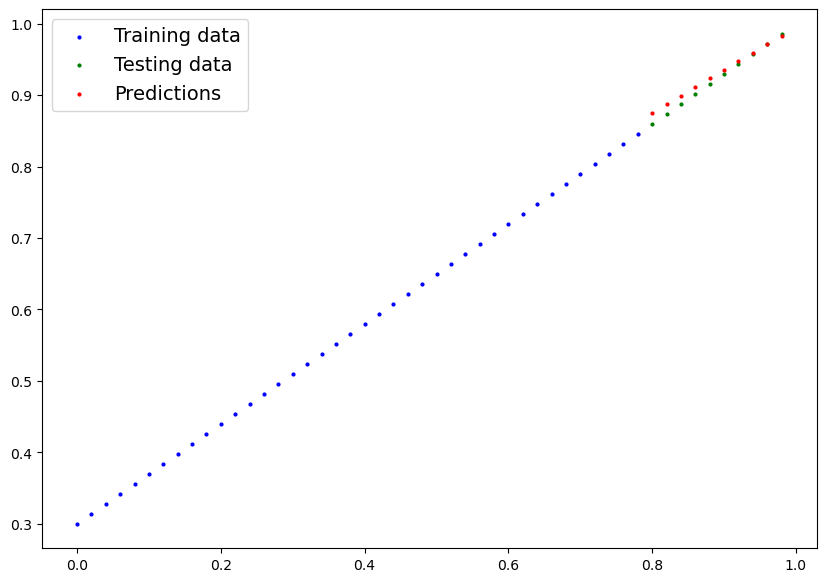

In [41]:
# Normally you'd have to put data on the CPU before you plot it
#    but earlier i was smart enough to account for that in my plot function
plot_predictions(predictions=y_preds)

In [42]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "stupid_regression_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/stupid_regression_model_1.pth


In [43]:
# load it back in to make sure that worked

# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


In [44]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')